In [4]:
import pandas as pd
import numpy as np
import pickle

# Load the pickled pipeline
with open('kidney_disease_model_pipeline.pkl', 'rb') as file:
    pipeline = pickle.load(file)

def calculate_bmi(weight, height):
    return weight / ((height / 100) ** 2)

def calculate_nutrition_needs(age, weight, height, ckd_stage, gfr):
    bmi = calculate_bmi(weight, height)
    
    # Base calculations - these should be adjusted based on medical expertise
    protein_per_kg = max(0.6, min(0.8, 1.2 - 0.1 * ckd_stage))  # Decreases with CKD stage
    calories_per_kg = 35 - (ckd_stage * 2)  # Slight decrease with CKD stage
    
    if bmi < 18.5:
        calories_per_kg += 5  # Increase calories for underweight
    elif bmi >= 30:
        calories_per_kg -= 5  # Decrease calories for obese
    
    if age > 60:
        calories_per_kg -= 2  # Slight decrease for older adults
    
    total_calories = weight * calories_per_kg
    protein_grams = weight * protein_per_kg
    carbs_grams = (total_calories * 0.55) / 4  # 55% of calories from carbs
    fat_grams = (total_calories * 0.30) / 9  # 30% of calories from fat
    
    # Adjust based on GFR
    if gfr < 60:
        protein_grams *= 0.9  # Further reduce protein for lower GFR
    
    # Electrolyte recommendations (these are simplified and should be adjusted by a dietitian)
    sodium_mg = 2000 - (ckd_stage * 200)  # Decrease sodium with CKD stage
    potassium_mg = max(2000, 4000 - (ckd_stage * 400))  # Decrease potassium with CKD stage
    phosphorus_mg = max(800, 1200 - (ckd_stage * 100))  # Decrease phosphorus with CKD stage
    
    return {
        "calories": round(total_calories),
        "protein": round(protein_grams),
        "carbs": round(carbs_grams),
        "fat": round(fat_grams),
        "sodium": round(sodium_mg),
        "potassium": round(potassium_mg),
        "phosphorus": round(phosphorus_mg)
    }

def predict_ckd_stage_and_recommend(age, weight, height, keratin, urea, gfr):
    # Prepare input data
    input_data = pd.DataFrame({
        'Age years': [age],
        'Weight': [weight],
        'Height': [height],
        'Blood Glucose Random': [keratin],  # Assuming keratin is used for Blood Glucose Random
        'Blood Urea': [urea],
        'Serum Creatinine': [keratin],  # Assuming keratin is used for Serum Creatinine
        'GFR': [gfr]
    })
    
    # Use the pipeline to predict CKD stage
    ckd_stage = pipeline.predict(input_data)[0]
    
    # Calculate nutritional needs
    nutrition_needs = calculate_nutrition_needs(age, weight, height, ckd_stage, gfr)
    
    return ckd_stage, nutrition_needs

# Example usage
age = 60
weight = 50  # kg
height = 164  # cm
keratin = 1.2  # mg/dL (assumed to be used for both Blood Glucose Random and Serum Creatinine)
urea = 40  # mg/dL
gfr = 60  # mL/min/1.73m^2

stage, nutrition = predict_ckd_stage_and_recommend(age, weight, height, keratin, urea, gfr)
print(f"Predicted CKD Stage: {stage}")
print("Nutritional Recommendations:")
for key, value in nutrition.items():
    print(f"{key.capitalize()}: {value} {'grams' if key in ['protein', 'carbs', 'fat'] else 'mg' if key != 'calories' else 'kcal'}")

Predicted CKD Stage: 2
Nutritional Recommendations:
Calories: 1550 kcal
Protein: 40 grams
Carbs: 213 grams
Fat: 52 grams
Sodium: 1600 mg
Potassium: 3200 mg
Phosphorus: 1000 mg


In [5]:
import pandas as pd
import numpy as np
import pickle

class CKDPredictionNutritionSystem:
    def __init__(self, pipeline_path):
        with open(pipeline_path, 'rb') as file:
            self.pipeline = pickle.load(file)

    def calculate_bmi(self, weight, height):
        return weight / ((height / 100) ** 2)

    def calculate_nutrition_needs(self, age, weight, height, ckd_stage, gfr):
        bmi = self.calculate_bmi(weight, height)
        
        protein_per_kg = max(0.6, min(0.8, 1.2 - 0.1 * ckd_stage))
        calories_per_kg = 35 - (ckd_stage * 2)
        
        if bmi < 18.5:
            calories_per_kg += 5
        elif bmi >= 30:
            calories_per_kg -= 5
        
        if age > 60:
            calories_per_kg -= 2
        
        total_calories = weight * calories_per_kg
        protein_grams = weight * protein_per_kg
        carbs_grams = (total_calories * 0.55) / 4
        fat_grams = (total_calories * 0.30) / 9
        
        if gfr < 60:
            protein_grams *= 0.9
        
        sodium_mg = 2000 - (ckd_stage * 200)
        potassium_mg = max(2000, 4000 - (ckd_stage * 400))
        phosphorus_mg = max(800, 1200 - (ckd_stage * 100))
        
        return {
            "calories": round(total_calories),
            "protein": round(protein_grams),
            "carbs": round(carbs_grams),
            "fat": round(fat_grams),
            "sodium": round(sodium_mg),
            "potassium": round(potassium_mg),
            "phosphorus": round(phosphorus_mg)
        }

    def predict_ckd_stage_and_recommend(self, age, weight, height, keratin, urea, gfr):
        input_data = pd.DataFrame({
            'Age years': [age],
            'Weight': [weight],
            'Height': [height],
            'Blood Glucose Random': [keratin],
            'Blood Urea': [urea],
            'Serum Creatinine': [keratin],
            'GFR': [gfr]
        })
        
        ckd_stage = self.pipeline.predict(input_data)[0]
        nutrition_needs = self.calculate_nutrition_needs(age, weight, height, ckd_stage, gfr)
        
        return ckd_stage, nutrition_needs

# Save the entire system
import dill

system = CKDPredictionNutritionSystem('kidney_disease_model_pipeline.pkl')
with open('ckd_prediction_nutrition_system.pkl', 'wb') as file:
    dill.dump(system, file)

print("CKD Prediction and Nutrition System saved as 'ckd_prediction_nutrition_system.pkl'")

# Example of how to load and use the saved system
with open('ckd_prediction_nutrition_system.pkl', 'rb') as file:
    loaded_system = dill.load(file)

age, weight, height, keratin, urea, gfr = 60, 50, 164, 1.2, 40, 60
stage, nutrition = loaded_system.predict_ckd_stage_and_recommend(age, weight, height, keratin, urea, gfr)

print(f"Predicted CKD Stage: {stage}")
print("Nutritional Recommendations:")
for key, value in nutrition.items():
    print(f"{key.capitalize()}: {value} {'grams' if key in ['protein', 'carbs', 'fat'] else 'mg' if key != 'calories' else 'kcal'}")

CKD Prediction and Nutrition System saved as 'ckd_prediction_nutrition_system.pkl'
Predicted CKD Stage: 2
Nutritional Recommendations:
Calories: 1550 kcal
Protein: 40 grams
Carbs: 213 grams
Fat: 52 grams
Sodium: 1600 mg
Potassium: 3200 mg
Phosphorus: 1000 mg


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       212
           2       1.00      1.00      1.00       190
           3       1.00      1.00      1.00       211
           4       1.00      1.00      1.00       179
           5       1.00      1.00      1.00       208

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



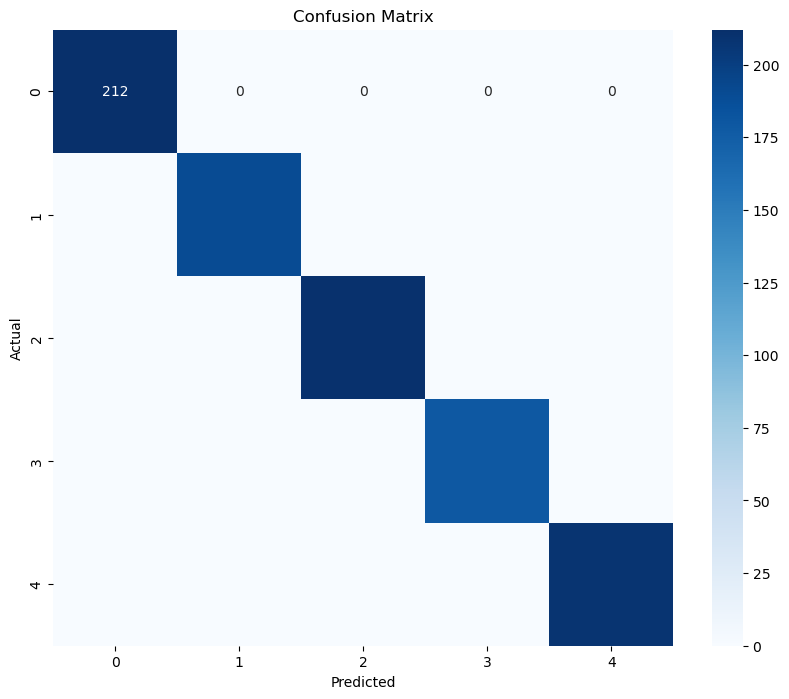

New CKD and Nutrition Prediction Model saved as 'new_ckd_nutrition_model.pkl'
Predicted CKD Stage: 2
Nutritional Recommendations:
Calories: 1550 kcal
Protein: 40 grams
Carbs: 213 grams
Fat: 52 grams
Sodium: 1600 mg
Potassium: 3200 mg
Phosphorus: 1000 mg


In [14]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

class NutritionRecommender(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X

    def calculate_bmi(self, weight, height):
        return weight / ((height / 100) ** 2)

    def calculate_nutrition_needs(self, X, ckd_stages):
        nutrition_list = []
        for i, stage in enumerate(ckd_stages):
            age = X['Age years'].iloc[i]
            weight = X['Weight'].iloc[i]
            height = X['Height'].iloc[i]
            gfr = X['GFR'].iloc[i]
            
            bmi = self.calculate_bmi(weight, height)
            
            protein_per_kg = max(0.6, min(0.8, 1.2 - 0.1 * stage))
            calories_per_kg = 35 - (stage * 2)
            
            if bmi < 18.5:
                calories_per_kg += 5
            elif bmi >= 30:
                calories_per_kg -= 5
            
            if age > 60:
                calories_per_kg -= 2
            
            total_calories = weight * calories_per_kg
            protein_grams = weight * protein_per_kg
            carbs_grams = (total_calories * 0.55) / 4
            fat_grams = (total_calories * 0.30) / 9
            
            if gfr < 60:
                protein_grams *= 0.9
            
            sodium_mg = 2000 - (stage * 200)
            potassium_mg = max(2000, 4000 - (stage * 400))
            phosphorus_mg = max(800, 1200 - (stage * 100))
            
            nutrition = {
                "calories": round(total_calories),
                "protein": round(protein_grams),
                "carbs": round(carbs_grams),
                "fat": round(fat_grams),
                "sodium": round(sodium_mg),
                "potassium": round(potassium_mg),
                "phosphorus": round(phosphorus_mg)
            }
            nutrition_list.append(nutrition)
        
        return nutrition_list

class CKDNutritionModel:
    def __init__(self):
        self.feature_names = ['Age years', 'Weight', 'Height', 'Blood Urea', 'Serum Creatinine', 'GFR']
        self.pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
        ])
        self.nutrition_recommender = NutritionRecommender()

    def fit(self, X, y):
        self.pipeline.fit(X, y)
        return self

    def predict(self, X):
        X = self._validate_input(X)
        ckd_stages = self.pipeline.predict(X)
        nutrition_recommendations = self.nutrition_recommender.calculate_nutrition_needs(X, ckd_stages)
        return list(zip(ckd_stages, nutrition_recommendations))

    def _validate_input(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        else:
            missing_features = set(self.feature_names) - set(X.columns)
            if missing_features:
                raise ValueError(f"Missing features: {missing_features}")
            X = X[self.feature_names]
        return X

# Load your dataset
# Replace this with your actual data loading code
data = pd.read_csv('large_simplified_ckd_dataset.csv')  # You'll need to provide your dataset

# Prepare your features and target
X = data[['Age years', 'Weight', 'Height', 'Blood Urea', 'Serum Creatinine', 'GFR']]
y = data['CKD_Stage']  # Assuming you have a column named 'CKD_Stage' in your dataset

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the new model
new_model = CKDNutritionModel()
new_model.fit(X_train, y_train)

# Make predictions
y_pred = new_model.pipeline.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Save the new model
with open('new_ckd_nutrition_model.pkl', 'wb') as file:
    pickle.dump(new_model, file)

print("New CKD and Nutrition Prediction Model saved as 'new_ckd_nutrition_model.pkl'")

# Example usage
with open('new_ckd_nutrition_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

sample_input = pd.DataFrame({
    'Age years': [60],
    'Weight': [50],
    'Height': [164],
    'Blood Urea': [40],
    'Serum Creatinine': [1.2],
    'GFR': [60]
})

prediction = loaded_model.predict(sample_input)

for ckd_stage, nutrition in prediction:
    print(f"Predicted CKD Stage: {ckd_stage}")
    print("Nutritional Recommendations:")
    for key, value in nutrition.items():
        print(f"{key.capitalize()}: {value} {'grams' if key in ['protein', 'carbs', 'fat'] else 'mg' if key != 'calories' else 'kcal'}")

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       212
           2       1.00      1.00      1.00       190
           3       1.00      1.00      1.00       211
           4       1.00      1.00      1.00       179
           5       1.00      1.00      1.00       208

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



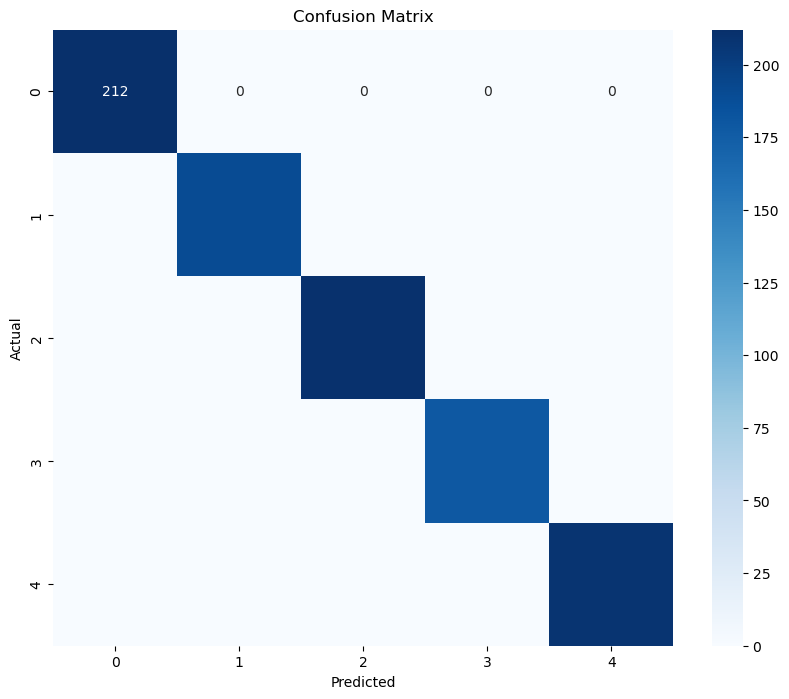

Complete model saved as 'ckd_nutrition_model.pkl'
Pipeline saved as 'ckd_pipeline.pkl'
Scaler saved as 'ckd_scaler.pkl'
Predicted CKD Stage: 2
Nutritional Recommendations:
Calories: 1550 kcal
Protein: 40 grams
Carbs: 213 grams
Fat: 52 grams
Sodium: 1600 mg
Potassium: 3200 mg
Phosphorus: 1000 mg


In [15]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

NutritionRecommender
class CKDNutritionModel:
    def __init__(self):
        self.feature_names = ['Age years', 'Weight', 'Height', 'Blood Urea', 'Serum Creatinine', 'GFR']
        self.scaler = StandardScaler()
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self.pipeline = Pipeline([
            ('scaler', self.scaler),
            ('clf', self.classifier)
        ])
        self.nutrition_recommender = NutritionRecommender()

    def fit(self, X, y):
        self.pipeline.fit(X, y)
        return self

    def predict(self, X):
        X = self._validate_input(X)
        ckd_stages = self.pipeline.predict(X)
        nutrition_recommendations = self.nutrition_recommender.calculate_nutrition_needs(X, ckd_stages)
        return list(zip(ckd_stages, nutrition_recommendations))

    def _validate_input(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        else:
            missing_features = set(self.feature_names) - set(X.columns)
            if missing_features:
                raise ValueError(f"Missing features: {missing_features}")
            X = X[self.feature_names]
        return X

# Load your dataset
data = pd.read_csv('large_simplified_ckd_dataset.csv')

# Prepare your features and target
X = data[['Age years', 'Weight', 'Height', 'Blood Urea', 'Serum Creatinine', 'GFR']]
y = data['CKD_Stage']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the new model
new_model = CKDNutritionModel()
new_model.fit(X_train, y_train)

# Make predictions
y_pred = new_model.pipeline.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Save the complete model
with open('ckd_nutrition_model.pkl', 'wb') as file:
    pickle.dump(new_model, file)

# Save the pipeline separately
with open('ckd_pipeline.pkl', 'wb') as file:
    pickle.dump(new_model.pipeline, file)

# Save the scaler separately
with open('ckd_scaler.pkl', 'wb') as file:
    pickle.dump(new_model.scaler, file)

print("Complete model saved as 'ckd_nutrition_model.pkl'")
print("Pipeline saved as 'ckd_pipeline.pkl'")
print("Scaler saved as 'ckd_scaler.pkl'")

# Example usage
with open('ckd_nutrition_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

sample_input = pd.DataFrame({
    'Age years': [60],
    'Weight': [50],
    'Height': [164],
    'Blood Urea': [40],
    'Serum Creatinine': [1.2],
    'GFR': [60]
})

prediction = loaded_model.predict(sample_input)

for ckd_stage, nutrition in prediction:
    print(f"Predicted CKD Stage: {ckd_stage}")
    print("Nutritional Recommendations:")
    for key, value in nutrition.items():
        print(f"{key.capitalize()}: {value} {'grams' if key in ['protein', 'carbs', 'fat'] else 'mg' if key != 'calories' else 'kcal'}")

In [17]:
sample_input = pd.DataFrame({
    'Age years': [40],
    'Weight': [90],
    'Height': [164],
    'Blood Urea': [50],
    'Serum Creatinine': [9.2],
    'GFR': [30]
})

prediction = loaded_model.predict(sample_input)
for ckd_stage, nutrition in prediction:
    print(f"Predicted CKD Stage: {ckd_stage}")
    print("Nutritional Recommendations:")
    for key, value in nutrition.items():
        print(f"{key.capitalize()}: {value} {'grams' if key in ['protein', 'carbs', 'fat'] else 'mg' if key != 'calories' else 'kcal'}")

Predicted CKD Stage: 3
Nutritional Recommendations:
Calories: 2160 kcal
Protein: 65 grams
Carbs: 297 grams
Fat: 72 grams
Sodium: 1400 mg
Potassium: 2800 mg
Phosphorus: 900 mg
